In [1]:
import h5py
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
from keras.layers import BatchNormalization
from keras.layers import Dense, Activation, Input, add, Dropout
from keras.models import Model
# from keras.optimizers import Adam <- This wasn't working?
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback

2022-06-12 18:46:03.989381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/afonso/root/lib
2022-06-12 18:46:03.989412: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import tensorflow as tf

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from plottingFunctions import sigBkgEff

In [6]:
file_path = ""

In [7]:
trainfile_name = file_path + "./My_Pb-training_sample-NN.h5"
h5f_train = h5py.File(trainfile_name, 'r')

In [8]:
X_train = h5f_train['X_train'][:]
Y_train = h5f_train['Y_train'][:]

In [9]:
# Testing!
print(X_train.shape)
print(Y_train.shape)

(154065, 69)
(154065, 3)


In [10]:
testfile_name = file_path + "./My_Pb-test-validation_sample-NN.h5"
h5f_test = h5py.File(testfile_name, 'r')

In [11]:
X_test = h5f_test['X_test'][:]
Y_test = h5f_test['Y_test'][:]
# Test train split is something to keep in mind!

In [12]:
# Testing!
print(X_test.shape)
print(Y_test.shape)

(750000, 69)
(750000, 3)


In the following the DL1 network is defined

In [13]:
# Input layer
inputs = Input(shape=(X_train.shape[1],))
# number of nodes in the different hidden layers
l_units = [72, 57, 60, 48, 36, 24, 12, 6]
x = inputs
# loop to initialise the hidden layers
for unit in l_units:
    x = Dense(units=unit, activation="linear", kernel_initializer='glorot_uniform')(x) # Activation "linear"?
    x = BatchNormalization()(x) # Interpreto isto como propriedade da Dense layer (introduz 'batch normalization' -> transforma o output
                                # para dar algo de média zero e desvio padrão 1. "Batch normalization applies a transformation that maintains 
                                # the mean output close to 0 and the output standard deviation close to 1" - Keras documentation.
            
    x = Activation('relu')(x)   # Interpreto isto como propriedade da Dense layer (altera a activation function de "linear" para 'relu')
    x = Dropout(0.1)(x)         # Could uncomment to introduce dropout (to reduce overfitting if needed)
# output layer, using softmax which will return a probability for each jet to be either light, c- or b-jet
predictions = Dense(units=3, activation='softmax',
                    kernel_initializer='glorot_uniform')(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

model_optimizer = Adam(learning_rate=0.01)
model.compile(  # loss='mse',
    loss='categorical_crossentropy', # categorical_crossentropy: It is used for multi-class classification.
    optimizer=model_optimizer,
    metrics=['accuracy']
)

2022-06-12 18:46:40.760207: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-12 18:46:40.760350: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (afonso-OMEN-by-HP-Laptop-15-ce0xx): /proc/driver/nvidia/version does not exist
2022-06-12 18:46:40.805341: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 69)]              0         
                                                                 
 dense (Dense)               (None, 72)                5040      
                                                                 
 batch_normalization (BatchN  (None, 72)               288       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 72)                0         
                                                                 
 dropout (Dropout)           (None, 72)                0         
                                                                 
 dense_1 (Dense)             (None, 57)                4161      
                                                             

In [14]:
def GetRejection(y_pred, y_true):
    """Calculates the c and light rejection for 77% WP and 0.018 c-fraction."""
    b_index, c_index, u_index = 2, 1, 0
    cfrac = 0.018
    target_beff = 0.77
    y_true = np.argmax(y_true, axis=1)
    b_jets = y_pred[y_true == b_index]
    c_jets = y_pred[y_true == c_index]
    u_jets = y_pred[y_true == u_index]
    bscores = np.log(b_jets[:, b_index] / (cfrac * b_jets[:, c_index] +
                                           (1 - cfrac) * b_jets[:, u_index]))
    cutvalue = np.percentile(bscores, 100.0 * (1.0 - target_beff))

    c_eff = len(c_jets[np.log(c_jets[:, b_index] / (cfrac * c_jets[:, c_index]
                                                    + (1 - cfrac) *
                                                    c_jets[:, u_index])) >
                       cutvalue]) / float(len(c_jets))
    u_eff = len(u_jets[np.log(u_jets[:, b_index] / (cfrac *
                                                    u_jets[:, c_index] +
                                                    (1 - cfrac) *
                                                    u_jets[:, u_index])) >
                       cutvalue]) / float(len(u_jets))

    if c_eff == 0 or u_eff == 0:
        return -1, -1
    return 1. / c_eff, 1. / u_eff


class MyCallback(Callback):
    """Custom callback function calculating per epoch light and c-rejection and saves the model of each epoch."""
    def __init__(self, X_valid=0, Y_valid=0,
                 model_name='test', store_all=False):
        self.X_valid = X_valid
        self.Y_valid = Y_valid
        self.result = []
        self.model_name = model_name
        os.system("mkdir -p %s" % self.model_name)
        self.dict_list = []
        self.store_all = store_all

    def on_epoch_end(self, epoch, logs=None):
        if self.store_all:
            self.model.save('%s/model_epoch%i.h5' % (self.model_name, epoch))
        y_pred = self.model.predict(self.X_valid, batch_size=5000)
        c_rej, u_rej = GetRejection(y_pred, self.Y_valid)
        dict_epoch = {
            "epoch": epoch,
            "loss": float(logs['loss']),
            "acc": float(logs['accuracy']),
            "val_loss": float(logs['val_loss']),
            "val_acc": float(logs['val_accuracy']),
            "c_rej": c_rej,
            "u_rej": u_rej
        }

        self.dict_list.append(dict_epoch)
        with open('%s/DictFile.json' % self.model_name, 'w') as outfile:
            json.dump(self.dict_list, outfile, indent=4)

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, # Reduce learning rate when a metric has stopped improving.
                              patience=5, min_lr=0.00001)
my_callback = MyCallback(X_valid=X_test,
                         Y_valid=Y_test,
                         model_name="DL1_example"
#                         ,store_all=True #flag to store model of each epoch
                        )

callbacks = [reduce_lr, my_callback]

model.fit(X_train, Y_train,
          validation_data = [X_test[:], Y_test[:]],
          epochs=10, # typically ~130 are necessary to converge
          batch_size=3000,
          callbacks=callbacks,
          )

Epoch 1/10
52/52 [==============================] - 6s 62ms/step - loss: 0.4535 - accuracy: 0.8262 - val_loss: 0.3576 - val_accuracy: 0.9394 - lr: 0.0100
Epoch 2/10
 7/52 [===>..........................] - ETA: 1s - loss: 0.1341 - accuracy: 0.9769

/tmp/ipykernel_25900/3192878355.py:14: RuntimeWarning: divide by zero encountered in true_divide
  c_eff = len(c_jets[np.log(c_jets[:, b_index] / (cfrac * c_jets[:, c_index]


52/52 [==============================] - 3s 63ms/step - loss: 0.1158 - accuracy: 0.9785 - val_loss: 0.4125 - val_accuracy: 0.9592 - lr: 0.0100
Epoch 3/10
52/52 [==============================] - 3s 57ms/step - loss: 0.0766 - accuracy: 0.9834 - val_loss: 0.0816 - val_accuracy: 0.9897 - lr: 0.0100
Epoch 4/10
 7/52 [===>..........................] - ETA: 0s - loss: 0.0583 - accuracy: 0.9871

/tmp/ipykernel_25900/3192878355.py:14: RuntimeWarning: divide by zero encountered in log
  c_eff = len(c_jets[np.log(c_jets[:, b_index] / (cfrac * c_jets[:, c_index]


52/52 [==============================] - 3s 59ms/step - loss: 0.0559 - accuracy: 0.9876 - val_loss: 0.1019 - val_accuracy: 0.9826 - lr: 0.0100
Epoch 5/10
52/52 [==============================] - 4s 69ms/step - loss: 0.0498 - accuracy: 0.9876 - val_loss: 0.0388 - val_accuracy: 0.9926 - lr: 0.0100
Epoch 6/10
52/52 [==============================] - 3s 63ms/step - loss: 0.0454 - accuracy: 0.9883 - val_loss: 0.0275 - val_accuracy: 0.9945 - lr: 0.0100
Epoch 7/10
52/52 [==============================] - 3s 49ms/step - loss: 0.0389 - accuracy: 0.9898 - val_loss: 0.0316 - val_accuracy: 0.9934 - lr: 0.0100
Epoch 8/10
52/52 [==============================] - 3s 51ms/step - loss: 0.0392 - accuracy: 0.9894 - val_loss: 0.0239 - val_accuracy: 0.9945 - lr: 0.0100
Epoch 9/10
52/52 [==============================] - 3s 51ms/step - loss: 0.0361 - accuracy: 0.9904 - val_loss: 0.0327 - val_accuracy: 0.9929 - lr: 0.0100
Epoch 10/10
52/52 [==============================] - 3s 56ms/step - loss: 0.0361 - accu

In [16]:
df_results = pd.read_json("DL1_example/DictFile.json")
df_results

,epoch,loss,acc,val_loss,val_acc,c_rej,u_rej
0,0,0.453537,0.826164,0.357593,0.939449,2688.172043,83333.333333
1,1,0.115757,0.978490,0.412532,0.959224,4464.285714,83333.333333
2,2,0.076585,0.983351,0.081602,0.989691,5208.333333,125000.000000
3,3,0.055921,0.987603,0.101879,0.982643,5434.782609,125000.000000
4,4,0.049763,0.987596,0.038843,0.992603,5813.953488,125000.000000
5,5,0.045367,0.988336,0.027547,0.994541,5681.818182,83333.333333
6,6,0.038945,0.989784,0.031567,0.993447,6250.000000,125000.000000
7,7,0.039158,0.989388,0.023944,0.994515,5208.333333,125000.000000
8,8,0.036101,0.990387,0.032720,0.992901,6097.560976,125000.000000
9,9,0.036104,0.990413,0.151448,0.981871,6097.560976,250000.000000


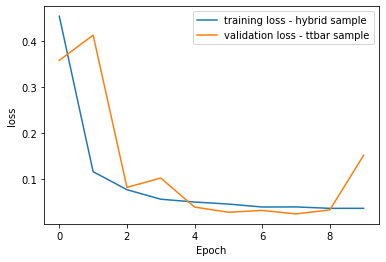

In [17]:
plt.plot(df_results['epoch'],df_results['loss'], label='training loss - hybrid sample')
plt.plot(df_results['epoch'],df_results['val_loss'], label='validation loss - ttbar sample')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

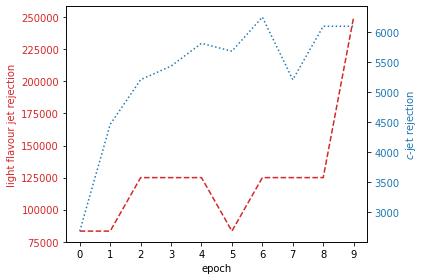

In [18]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('light flavour jet rejection', color=color)
ax1.plot(df_results["epoch"],df_results['u_rej'], '--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'$c$-jet rejection', color=color)  # we already handled the x-label with ax1
ax2.plot(df_results["epoch"], df_results['c_rej'], ':', color=color, label='std = 0.12')
ax2.tick_params(axis='y', labelcolor=color)

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

fig.tight_layout()

## Hyper parameter optimisation
You can play with different hyper parameters and see their impact.
The largest impact has the NN-structure itself, you can try changing the number of hidden layers and their number of nodes
Other hyper parameters are the learning rate, activation function, batch size


## Model Evaluation

In [19]:
b_effs = np.linspace(0.39, 1, 150)
# l_rej = 1./np.load("DL1r-extbeff-22M.npy", allow_pickle=True).item().get('urej') # This will also be a problem! Remember! Actually, I guess, we can just ignore these
# c_rej = 1./np.load("DL1r-extbeff-22M.npy", allow_pickle=True).item().get('crej') # 'recommendations', and it'll be fine. I hope. I should ask the teacher...

# l_rej_Z = 1./np.load("DL1r-extbeff-22M-ext-Zprime.npy", allow_pickle=True).item().get('urej')
# c_rej_Z = 1./np.load("DL1r-extbeff-22M-ext-Zprime.npy", allow_pickle=True).item().get('crej')

In [20]:
# To draw the roc curves faster, look at a subset of the test dataset. 
nTest = 50000

./My_Pb-test-validation_sample-NN.h5
1563/1563 [==============================] - 3s 2ms/step


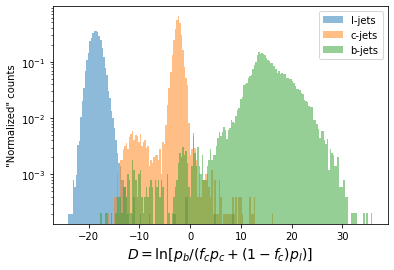

In [21]:
dl1_leffs, dl1_ceffs, dl1_beffs, dl1_discs = [], [], [], []

for testfile_name in [file_path+"./My_Pb-test-validation_sample-NN.h5"]:
    
    print(testfile_name)
    h5f_test = h5py.File(testfile_name, 'r')

    X_test = h5f_test['X_test'][500000:]
    y_test = h5f_test['Y_test'][500000:]
    
    h5f_test.close()

    (leff, ceff, beff), d = sigBkgEff(model, X_test[:nTest], y_test[:nTest], returnDisc=True, fc=0.018)
     
    dl1_leffs.append(leff)
    dl1_ceffs.append(ceff)
    dl1_beffs.append(beff)
    dl1_discs.append(d)

/tmp/ipykernel_25900/2656432645.py:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(dl1_beffs[0], 1 / dl1_leffs[0], color='C4', label='l-rej')
/tmp/ipykernel_25900/2656432645.py:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(dl1_beffs[0], 1 / dl1_ceffs[0],"--", color='C4', label='c-rej')
/tmp/ipykernel_25900/2656432645.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,3000)


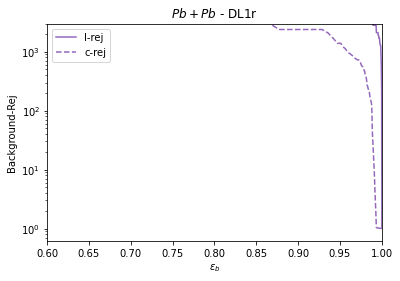

In [22]:
# Pb+Pb
plt.figure()
plt.plot(dl1_beffs[0], 1 / dl1_leffs[0], color='C4', label='l-rej')
# plt.plot(b_effs, 1./l_rej, color='C2', label='l-rej - new recommendations')

# plt.figure()
plt.plot(dl1_beffs[0], 1 / dl1_ceffs[0],"--", color='C4', label='c-rej')
# plt.plot(b_effs, 1./c_rej, "--", color='C2', label='c-rej - new recommendations')

plt.ylabel('Background-Rej')
plt.xlabel(r'$\epsilon_b$')

plt.legend()
plt.title(r'$Pb+Pb$ - DL1r')
plt.yscale("log")
plt.xlim(0.6,1)
plt.ylim(0,3000)

plt.show()